やること
- mbdのrateのヒストの確認(2021/02 - )
- クラス候補案を出す（percentileから決める（分類数を揃えるため））
- row_id, rateを作成して、csvにする（それで後でmerge)

【結論】  
< class分類 >
全データでクラス分類を行うときの候補としては、下記  
class0: 0.953  
class1: 0.996  
class2: 1  
class3: 1.008  
class4: 1.063  
（正規分布と仮定したときに1σくらいまでは同じくらいの数で細かく分類して、それより外側は外側という括りにしても良いかも？予測精度をどこまで求めるかによるが）  
  
< 追加検討 >
activeの値で分類したときには、比率はどうなっているのかを確認  
→activeが大きいほど、分布としては変化率が小さい（1近傍に集中する）が、最大・最小の値も大きくなっている（ここの予測の対処の仕方は工夫点かも？アイデアはまだ整理できていないけど）

# mbdのヒスト確認　＆　クラス候補案

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

/Users/akimoto/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Filepath
train_filepath = "../data/raw/train.csv"
revealed_filepath = "../data/raw/revealed_test.csv"
test_filepath = "../data/raw/test.csv"

In [3]:
train = pd.read_csv(train_filepath)
revealed = pd.read_csv(revealed_filepath)

In [4]:
# Concat
train = pd.concat([train, revealed])
train = train.sort_values(["row_id", "cfips"])
train.reset_index(drop=True, inplace=True)
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,10001_2019-08-01,10001,Kent County,Delaware,2019-08-01,4.995701,6624
1,10001_2019-09-01,10001,Kent County,Delaware,2019-09-01,5.031902,6672
2,10001_2019-10-01,10001,Kent County,Delaware,2019-10-01,5.098270,6760
3,10001_2019-11-01,10001,Kent County,Delaware,2019-11-01,5.124666,6795
4,10001_2019-12-01,10001,Kent County,Delaware,2019-12-01,5.086203,6744


In [5]:
# 比率作成時に0割が発生するので、0の行は除く
train = train.query("microbusiness_density != 0")
train

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,10001_2019-08-01,10001,Kent County,Delaware,2019-08-01,4.995701,6624
1,10001_2019-09-01,10001,Kent County,Delaware,2019-09-01,5.031902,6672
2,10001_2019-10-01,10001,Kent County,Delaware,2019-10-01,5.098270,6760
3,10001_2019-11-01,10001,Kent County,Delaware,2019-11-01,5.124666,6795
4,10001_2019-12-01,10001,Kent County,Delaware,2019-12-01,5.086203,6744
...,...,...,...,...,...,...,...
128530,9015_2022-08-01,9015,Windham County,Connecticut,2022-08-01,3.552985,3323
128531,9015_2022-09-01,9015,Windham County,Connecticut,2022-09-01,3.567954,3337
128532,9015_2022-10-01,9015,Windham County,Connecticut,2022-10-01,3.566885,3336
128533,9015_2022-11-01,9015,Windham County,Connecticut,2022-11-01,3.573300,3342


In [6]:
# 比率の特徴呂作成
train["shift_1_mbd"] = train.groupby("cfips")["microbusiness_density"].shift(1)
train = train.fillna(method="bfill")
train["rate_shift1"] = train["microbusiness_density"] / train["shift_1_mbd"]

In [7]:
#　2021/02 以降のデータの抽出
train["first_day_of_month"] = pd.to_datetime(train["first_day_of_month"])
extract_train = train.query("first_day_of_month >= '2021-02-01'")

In [8]:
extract_train.reset_index(inplace=True)

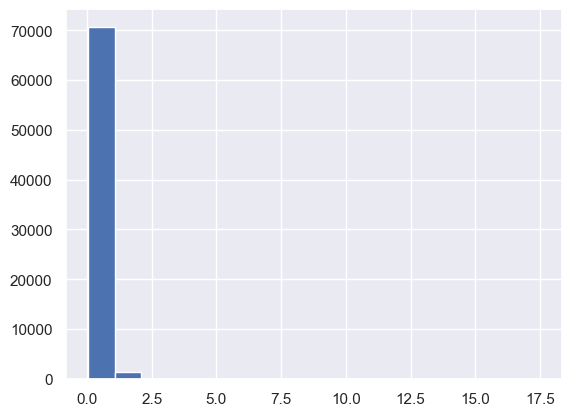

In [9]:
# ヒストグラムの描画
bins = int(np.log2(len(train)) + 1)
plt.hist(extract_train["rate_shift1"], bins=bins)
plt.show()

In [10]:
extract_train["rate_shift1"].describe()

count    72081.000000
mean         1.004128
std          0.099463
min          0.048310
25%          0.994778
50%          1.000649
75%          1.009469
max         17.463277
Name: rate_shift1, dtype: float64

-> 極端に大きいものと小さいものが存在している  
-> 弾く

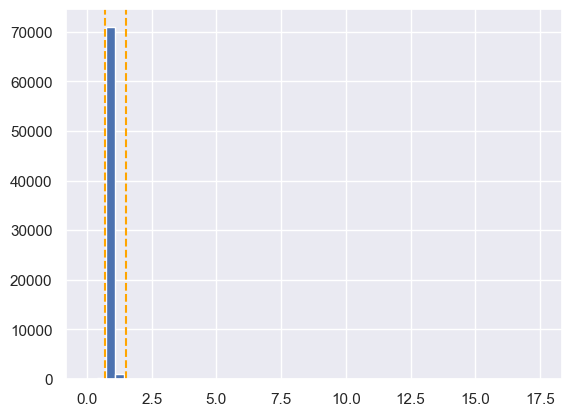

In [11]:
top = 99.9; bottom = 0.1
percentile_top     = np.percentile(extract_train["rate_shift1"], top)
percentile_bottom  = np.percentile(extract_train["rate_shift1"], bottom)

# ヒストグラムの描画
# bins = int(np.log2(len(train)) + 1)
bins = 50
plt.hist(extract_train["rate_shift1"], bins=bins)
plt.axvline(percentile_top, linestyle="dashed", c="orange")
plt.axvline(percentile_bottom, linestyle="dashed", c="orange")
plt.show()

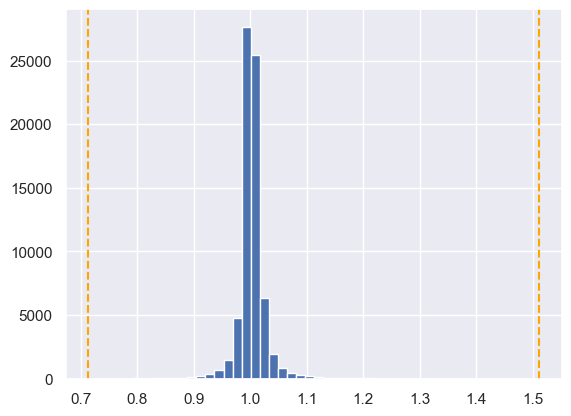

In [12]:
top = 99.9; bottom = 0.1
percentile_top     = np.percentile(extract_train["rate_shift1"], top)
percentile_bottom  = np.percentile(extract_train["rate_shift1"], bottom)

pick_data = extract_train.query("@percentile_bottom <= rate_shift1 <= @percentile_top")
# ヒストグラムの描画
# bins = int(np.log2(len(train)) + 1)
bins = 50
plt.hist(pick_data["rate_shift1"], bins=bins)
plt.axvline(percentile_top, linestyle="dashed", c="orange")
plt.axvline(percentile_bottom, linestyle="dashed", c="orange")
plt.show()

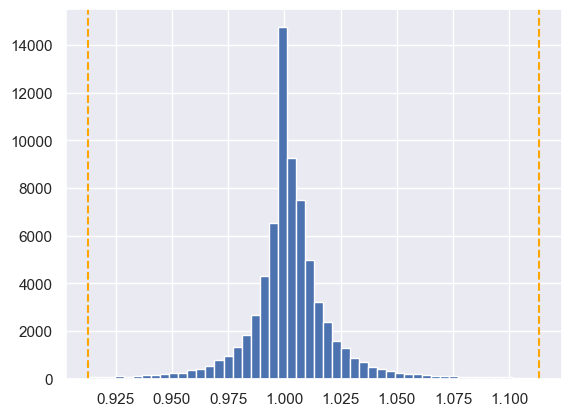

In [13]:
top = 99; bottom = 1
percentile_top     = np.percentile(extract_train["rate_shift1"], top)
percentile_bottom  = np.percentile(extract_train["rate_shift1"], bottom)

pick_data = extract_train.query("@percentile_bottom <= rate_shift1 <= @percentile_top")
# ヒストグラムの描画
# bins = int(np.log2(len(train)) + 1)
bins = 50
plt.hist(pick_data["rate_shift1"], bins=bins)
plt.axvline(percentile_top, linestyle="dashed", c="orange")
plt.axvline(percentile_bottom, linestyle="dashed", c="orange")
plt.show()

In [14]:
# ５クラスに分類
class_num = 5
increment = 100 / class_num
percentile_list = []
value = 0
while value <= 100:
    percentile_list.append(value)
    value += increment

percentile_value_list = [0 for _ in range(len(percentile_list))]
for i in range(len(percentile_list)-1):
    percentile_bottom = percentile_list[i]
    percentile_top = percentile_list[i+1]
    
    percentile_bottom_value = np.percentile(pick_data["rate_shift1"], percentile_bottom)
    percentile_top_value    = np.percentile(pick_data["rate_shift1"], percentile_top)
    # 確認のため
    tmp_df = pick_data.query("@percentile_bottom_value <= rate_shift1 < @percentile_top_value")
    data_num = len(tmp_df)
    
    percentile_value_list[i] = percentile_bottom_value
    print(f"{percentile_bottom_value:.3e} <= rate_shift1 < {percentile_top_value:.3e}")
    print(f"data_number:{data_num}")
    print()
else:
    percentile_value_list[i+1] = percentile_top_value

9.128e-01 <= rate_shift1 < 9.926e-01
data_number:14128

9.926e-01 <= rate_shift1 < 1.000e+00
data_number:11988

1.000e+00 <= rate_shift1 < 1.004e+00
data_number:16267

1.004e+00 <= rate_shift1 < 1.012e+00
data_number:14128

1.012e+00 <= rate_shift1 < 1.113e+00
data_number:14127



In [15]:
percentile_value_list

[0.9128358694372245,
 0.9925608787797536,
 1.0,
 1.003816790595688,
 1.0119579699184165,
 1.1132075849120338]

class0 candidate:0.953
class1 candidate:0.996
class2 candidate:1.002
class3 candidate:1.008
class4 candidate:1.063


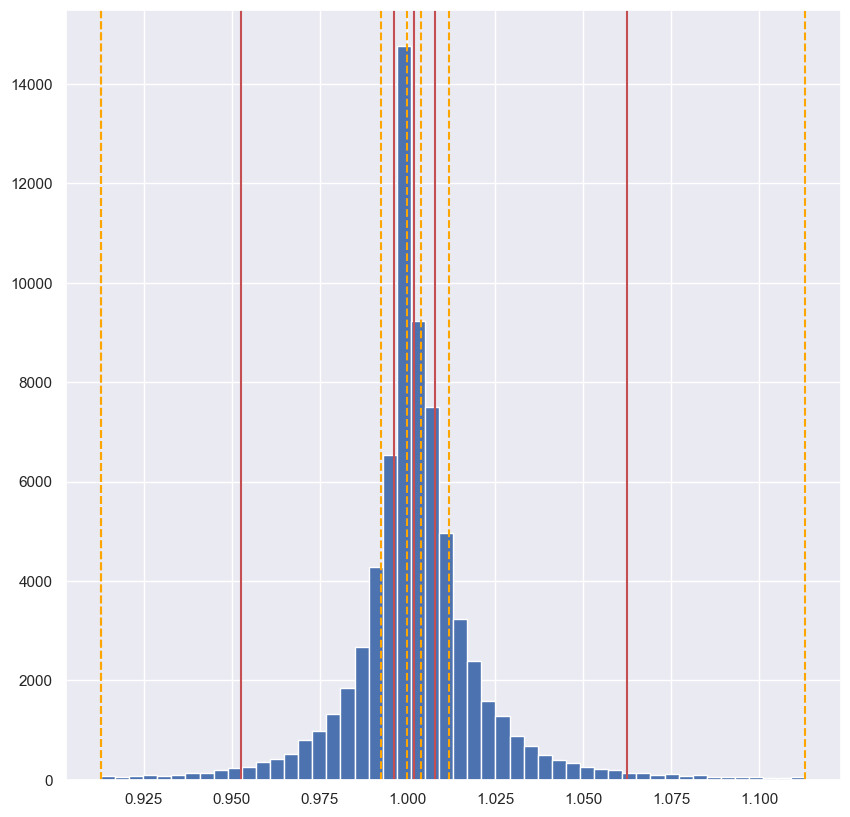

In [17]:
# ヒストグラムの描画
# bins = int(np.log2(len(train)) + 1)
bins = 50
plt.figure(figsize=(10,10))
plt.hist(pick_data["rate_shift1"], bins=bins)
plt.axvline(percentile_value_list[0], linestyle="dashed", c="orange")
class_candidate_list = []
for i in range(len(percentile_value_list)-1):
    percentile_value = percentile_value_list[i]
    percentile = percentile_list[i]
    mean = (percentile_value_list[i]+percentile_value_list[i+1])/2
    class_candidate_list.append(mean)
    print(f"class{i} candidate:{mean:.3f}")
    plt.axvline(percentile_value, linestyle="dashed", c="orange")
    plt.axvline(mean, linestyle="solid", c="r")
plt.axvline(percentile_value_list[-1], linestyle="dashed", c="orange")
    
plt.show()

0.992 - 1の間にデータは1近傍にデータが偏り気味  

### activeでヒストが変わるかどうか確認

In [72]:
# Filepath
train_filepath = "../data/raw/train.csv"
revealed_filepath = "../data/raw/revealed_test.csv"
test_filepath = "../data/raw/test.csv"

In [73]:
train = pd.read_csv(train_filepath)
revealed = pd.read_csv(revealed_filepath)

In [74]:
# Concat
train = pd.concat([train, revealed])
train = train.sort_values(["row_id", "cfips"])
train.reset_index(drop=True, inplace=True)
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,10001_2019-08-01,10001,Kent County,Delaware,2019-08-01,4.995701,6624
1,10001_2019-09-01,10001,Kent County,Delaware,2019-09-01,5.031902,6672
2,10001_2019-10-01,10001,Kent County,Delaware,2019-10-01,5.098270,6760
3,10001_2019-11-01,10001,Kent County,Delaware,2019-11-01,5.124666,6795
4,10001_2019-12-01,10001,Kent County,Delaware,2019-12-01,5.086203,6744


In [75]:
train["active"].describe()

count    1.285350e+05
mean     6.461169e+03
std      3.311759e+04
min      0.000000e+00
25%      1.450000e+02
50%      4.900000e+02
75%      2.126500e+03
max      1.167744e+06
Name: active, dtype: float64

In [76]:
# 比率の特徴呂作成
train["shift_1_mbd"] = train.groupby("cfips")["microbusiness_density"].shift(1)
train = train.fillna(method="bfill")
train["rate_shift1"] = train["microbusiness_density"] / train["shift_1_mbd"]

In [77]:
#　2021/02 以降のデータの抽出
train["first_day_of_month"] = pd.to_datetime(train["first_day_of_month"])
extract_train = train.query("first_day_of_month >= '2021-02-01'")

In [78]:
train["active"].describe()

count    1.285350e+05
mean     6.461169e+03
std      3.311759e+04
min      0.000000e+00
25%      1.450000e+02
50%      4.900000e+02
75%      2.126500e+03
max      1.167744e+06
Name: active, dtype: float64

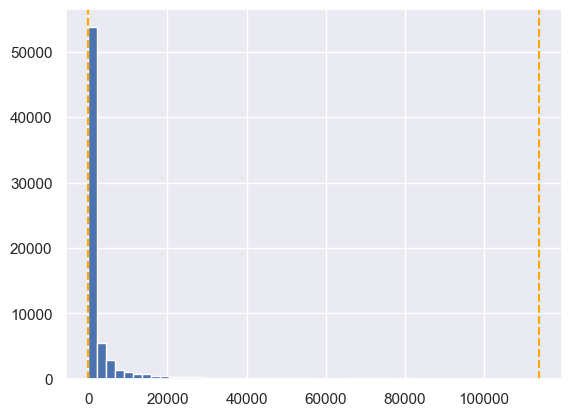

In [79]:
top = 99; bottom = 1
percentile_top     = np.percentile(extract_train["active"], top)
percentile_bottom  = np.percentile(extract_train["active"], bottom)

pick_data = extract_train.query("@percentile_bottom <= active <= @percentile_top")
# ヒストグラムの描画
# bins = int(np.log2(len(train)) + 1)
bins = 50
plt.hist(pick_data["active"], bins=bins)
plt.axvline(percentile_top, linestyle="dashed", c="orange")
plt.axvline(percentile_bottom, linestyle="dashed", c="orange")
plt.show()

In [80]:
active = extract_train["active"].values
log_active = np.log(active + 1)
extract_train = extract_train.copy()
extract_train["log_active"] = log_active

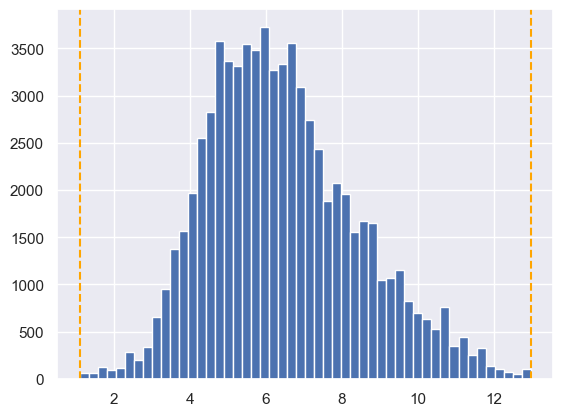

In [81]:
top = 99.9; bottom = 0.1
percentile_top     = np.percentile(extract_train["log_active"], top)
percentile_bottom  = np.percentile(extract_train["log_active"], bottom)

pick_data = extract_train.query("@percentile_bottom <= log_active <= @percentile_top")
# ヒストグラムの描画
# bins = int(np.log2(len(train)) + 1)
bins = 50
plt.hist(pick_data["log_active"], bins=bins)
plt.axvline(percentile_top, linestyle="dashed", c="orange")
plt.axvline(percentile_bottom, linestyle="dashed", c="orange")
plt.show()

In [82]:
# 3クラスに分類
class_num = 3
increment = 100 / class_num
percentile_list = []
value = 0
while value <= 100:
    percentile_list.append(value)
    value += increment

percentile_value_list = [0 for _ in range(len(percentile_list))]
for i in range(len(percentile_list)-1):
    percentile_bottom = percentile_list[i]
    percentile_top = percentile_list[i+1]
    
    percentile_bottom_value = np.percentile(pick_data["log_active"], percentile_bottom)
    percentile_top_value    = np.percentile(pick_data["log_active"], percentile_top)
    # 確認のため
    tmp_df = pick_data.query("@percentile_bottom_value <= log_active < @percentile_top_value")
    data_num = len(tmp_df)
    
    percentile_value_list[i] = percentile_bottom_value
    print(f"{percentile_bottom_value:.3e} <= log_active < {percentile_top_value:.3e}")
    print(f"data_number:{data_num}")
    print()
else:
    percentile_value_list[i+1] = percentile_top_value

1.099e+00 <= log_active < 5.407e+00
data_number:23914

5.407e+00 <= log_active < 7.072e+00
data_number:24055

7.072e+00 <= log_active < 1.297e+01
data_number:23993



In [83]:
pick_data = pick_data.copy()
pick_data["class_active"] = 0
for i in range(len(percentile_value_list)-1):
    pick_data.loc[(percentile_value_list[i] <= pick_data["log_active"])&(pick_data["log_active"] < percentile_value_list[i+1]), "class_active"] = i
pick_data["class_active"].value_counts()

1    24055
2    23993
0    23915
Name: class_active, dtype: int64

////////// class_0 //////////


count    23915.000000
mean         1.003740
std          0.067411
min          0.149425
25%          0.988889
50%          1.000000
75%          1.014925
max          5.083333
Name: rate_shift1, dtype: float64

//////////////////////////////

////////// class_1 //////////


count    24055.000000
mean         1.003970
std          0.071929
min          0.078129
25%          0.994186
50%          1.001490
75%          1.009346
max          8.730769
Name: rate_shift1, dtype: float64

//////////////////////////////

////////// class_2 //////////


count    23993.000000
mean         1.004692
std          0.141430
min          0.048310
25%          0.997420
50%          1.002099
75%          1.007034
max         17.463277
Name: rate_shift1, dtype: float64

//////////////////////////////



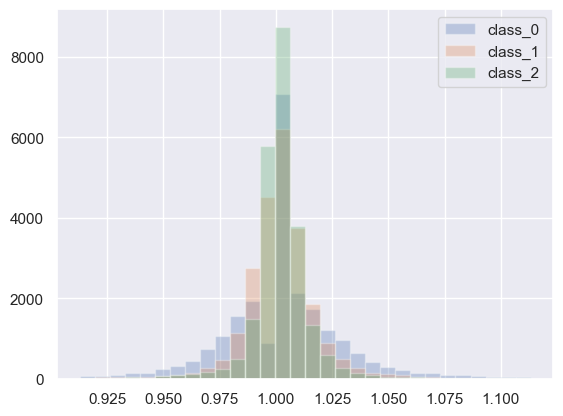

In [87]:
# class_activeごとにrate_shiftの確認
range_max = np.percentile(pick_data["rate_shift1"], 99)
range_min = np.percentile(pick_data["rate_shift1"], 1)
bins = 30
plt.figure()

for i in range(3):
    print("/"*10, f"class_{i}", "/"*10)
    tmp_df = pick_data.query("class_active == @i")
    display(tmp_df["rate_shift1"].describe())
    
    plt.hist(tmp_df["rate_shift1"], label=f"class_{i}", alpha=0.3, range=(range_min, range_max), bins=bins)
    print("/"*30)
    print()
plt.legend()
plt.show()

- activeのクラスによりrateの分布は変わる
- activeが大きいほど、変化率は1近傍に集中している（ただし、min, maxに着目すると極端な値があるために分散が大きくなっていると考えられる　 ->　予測が難しい部分？工夫すべき点？

# row_id, targetのcsv出力

In [47]:
# ※　0割が発生して、infになったところは99.9percentileで置換
# ※もとのrow_idの並びとは異なる
# ※比率作成の都合上2019-08-01の比率はすべて1になっている

In [37]:
train = pd.read_csv(train_filepath)
revealed = pd.read_csv(revealed_filepath)

In [38]:
# Concat
train = pd.concat([train, revealed])
train = train.sort_values(["row_id", "cfips"])
train.reset_index(drop=True, inplace=True)
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,10001_2019-08-01,10001,Kent County,Delaware,2019-08-01,4.995701,6624
1,10001_2019-09-01,10001,Kent County,Delaware,2019-09-01,5.031902,6672
2,10001_2019-10-01,10001,Kent County,Delaware,2019-10-01,5.098270,6760
3,10001_2019-11-01,10001,Kent County,Delaware,2019-11-01,5.124666,6795
4,10001_2019-12-01,10001,Kent County,Delaware,2019-12-01,5.086203,6744


In [39]:
# 比率の特徴呂作成
train["shift_1_mbd"] = train.groupby("cfips")["microbusiness_density"].shift(1)
train = train.fillna(method="bfill")
train["rate_shift1"] = train["microbusiness_density"] / train["shift_1_mbd"]

In [40]:
max(train["rate_shift1"])

inf

In [41]:
a = train["rate_shift1"]==float("inf")
sum(a)

3

In [42]:
# 0割によりinfになったところは、99percentileで置換
train.loc[train["rate_shift1"]==float("inf"), "rate_shift1"] = np.percentile(train["rate_shift1"], 99.9)

In [43]:
max(train["rate_shift1"])

48.35498596499827

In [44]:
a = train["rate_shift1"]==float("inf")
sum(a)

0

In [46]:
output = train[["row_id", "rate_shift1"]]
output = output.rename(columns={"rate_shift1":"target"})
output

,row_id,target
0,10001_2019-08-01,1.000000
1,10001_2019-09-01,1.007246
2,10001_2019-10-01,1.013189
3,10001_2019-11-01,1.005178
4,10001_2019-12-01,0.992495
...,...,...
128530,9015_2022-08-01,0.994017
128531,9015_2022-09-01,1.004213
128532,9015_2022-10-01,0.999700
128533,9015_2022-11-01,1.001799


In [48]:
output.to_csv("rate_shift1.csv", index=False)